# Barghi et al. (2019) Data Processing and Analysis

## Setup

In [4]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [5]:
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import matplotlib as mpl

In [6]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [7]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [8]:
np.random.seed(0)

# Data and Annotation Loading

### Load in SyncFile

In [9]:
CACHED_SYNC = '../data/barghi_et_al_2019/barghi_et_al_2019.hdf5'
SYNC_FILE = '../data/barghi_et_al_2019/Dsim_F0-F60_Q20_polymorphic_CMH_FET_blockID.sync.gz'

if not os.path.exists(CACHED_SYNC):
    sf = vf.SyncFile(SYNC_FILE)
    sf.dump_hdf5(CACHED_SYNC)
else:
    sf = vf.SyncFile.load_hdf5(CACHED_SYNC)

total time to load HDF5 file: 0.15662474632263185 mins.


In [10]:
sf_gi = sf.build_gintervals()
sf_gi.seqlens = dict()
with open('../data/dsimulans/dsim-M252-seqlens.txt') as f:
    for line in f:
        seqid, length = line.strip().split('\t')
        sf_gi.seqlens[seqid] = int(length)

In [11]:
keep_seqids = ['2L', '2R', '3L', '3R', 'X']
keep_autos = ['2L', '2R', '3L', '3R']

### Study Design

Next, we parse the sample names  the `README.docx` file (https://datadryad.org/resource/doi:10.5061/dryad.rr137kn/1).

From the readme, the sample name formats are,

```
for the base populations:      species_population_selectionRegime_replicate: e.g. Dsim_Fl_Base_4 
for the evolved populations:   species_population_selectionRegime_generation_replicate: e.g. Dsim_Fl_Hot_F13_1
```

which we parse using regular expressions:

In [12]:
CACHED_DESIGN = '../data/barghi_et_al_2019/barghi_et_al_2019_design.feather'

if not os.path.exists(CACHED_DESIGN):
    RAW_DESIGN_FILE = '../data/barghi_et_al_2019/barghi_et_al_2019_design.txt'
    sample_names = pd.read_csv(RAW_DESIGN_FILE, header=None, names=('col', ))['col'].tolist()
    sample_re = re.compile(r"(?P<species>Dsim)_(?P<pop>Fl)_(?P<selection>Base|Hot)_(F(?P<gen>\d+)_)?(?P<rep>\d+)")
    sample_info = [{'name':d, **re.match(sample_re, d).groupdict()} for d in sample_names]
    design = pd.DataFrame.from_dict(sample_info)
    
    # Barghi et al use base population to refer to generation zero — we set that explicitly here:
    design.loc[design.gen.isnull(), 'gen'] = 0
    design['gen'] = design['gen'].astype('int')
    
    design.to_feather(CACHED_DESIGN)
else:
    design = pd.read_feather(CACHED_DESIGN)

Our `TemporalFreqs()` and `TiledTemporalFreqs()` objects take a list of tuples `(timepoint, replicate)`, which we create via the design DataFrame:

In [13]:
samples = [(int(t), int(r)) for t, r in zip(design['rep'].values, design['gen'].values)]

### Import Annotation

We use the M252 reference genome annotation described by Palmieriet al. (2015). 
These sequence lengths are used for the creation of the tiles.

In [14]:
gtf_file = '../data/dsimulans/dsim-M252-popgen-ann-r1.1.sorted.gtf'
keep_seqids = set('2L 2R 3L 3R 4 X'.split())
dsim = GenomicIntervals.from_gff(gtf_file, filter_type='exon', filter_seqids=keep_seqids, delims=(' ', '; '))

In [15]:
dsim

GenomicIntervals — 6 unique seqids, 169132 features
   GenomicInterval seqid          source  type   score strand phase attributes
0  2L:[3589, 4976)    2L       Cufflinks  exon  1000.0      -     .       None
1  2L:[4846, 4976)    2L  protein2genome  exon     NaN      -     1       None
2  2L:[4846, 4976)    2L  protein2genome  exon     NaN      -     1       None
3  2L:[4846, 4976)    2L  protein2genome  exon     NaN      -     1       None
4  2L:[4941, 4976)    2L  protein2genome  exon     NaN      -     2       None
[ 169127 more GenomicIntervals ]

In [16]:
dsim.infer_seqlens()

## Covariance Analysis

### Creating Tiles

In [17]:
tile_width = 1e5
tile_width_label = '1e5'
tiles = GenomicIntervals.from_tiles(dsim.seqlens, width=tile_width)
# add in exonic basepairs:
#tiles = tiles.overlap_coverage(dsim, colname='exonic_bp')

### Creating TiledTemporalFreqs object

In [20]:
d = TiledTemporalFreqs(tiles, freqs=sf.freqs.T, depths=sf.N.T, diploids=1000, gintervals=sf_gi, samples=samples)

In [21]:
d.freqs.shape

(10, 7, 5096200)

In [49]:
del sf

How many windows and what's the mean and median number of loci per window?

In [19]:
nloci = np.array([len(x) for x in d.tile_indices])
print(f"mean number of loci: {nloci.mean()}")
print(f"median number of loci: {np.median(nloci)}")

mean number of loci: 4604.064195298372
median number of loci: 4830.0


### Genome-wide Covariances

In [51]:
gw_covs = d.calc_cov(use_masked=True)

In [52]:
stack_temporal_covariances(gw_covs, d.R, d.T).mean(axis=2)

array([[ 1.99536683e-02,  1.98915322e-03,  5.13232331e-04,
         5.64226147e-04, -1.46061844e-05, -3.51257652e-04],
       [ 1.98915322e-03,  1.93218299e-02,  1.88615452e-03,
         5.76139824e-04,  2.68056584e-04, -2.61949568e-04],
       [ 5.13232331e-04,  1.88615452e-03,  1.69551652e-02,
         2.45187425e-03,  9.89776702e-04,  2.77426981e-04],
       [ 5.64226147e-04,  5.76139824e-04,  2.45187425e-03,
         1.67597833e-02,  1.35323177e-03,  1.30403421e-04],
       [-1.46061844e-05,  2.68056584e-04,  9.89776702e-04,
         1.35323177e-03,  1.27813462e-02,  1.58093345e-03],
       [-3.51257652e-04, -2.61949568e-04,  2.77426981e-04,
         1.30403421e-04,  1.58093345e-03,  1.07419246e-02]])

### Genome-wide Covariances Ignoring Fixations

In [29]:
freqs_nofix = np.array(sf.freqs, copy=True)
freqs_nofix[np.logical_or(freqs_nofix == 0., freqs_nofix == 1.0)] = np.nan

In [30]:
d_nofix = TiledTemporalFreqs(tiles, freqs=freqs_nofix.T, depths=sf.N.T, diploids=1000, gintervals=sf_gi, samples=samples)

In [31]:
gw_covs_nofix = d_nofix.calc_cov(use_masked=True)

In [32]:
stack_temporal_covariances(gw_covs_nofix, d.R, d.T).mean(axis=2)

array([[ 2.26321038e-02,  1.34340538e-03,  5.49222327e-04,
         7.13923533e-04, -6.14925503e-05, -5.23078738e-04],
       [ 1.34340538e-03,  2.13182937e-02,  1.35914352e-03,
         6.69059772e-04,  2.75911458e-04, -3.69531829e-04],
       [ 5.49222327e-04,  1.35914352e-03,  1.86134924e-02,
         1.96319061e-03,  1.11928390e-03,  3.01680285e-04],
       [ 7.13923533e-04,  6.69059772e-04,  1.96319061e-03,
         1.84886515e-02,  6.17512355e-04,  1.07115603e-04],
       [-6.14925503e-05,  2.75911458e-04,  1.11928390e-03,
         6.17512355e-04,  1.42780911e-02,  9.49322422e-04],
       [-5.23078738e-04, -3.69531829e-04,  3.01680285e-04,
         1.07115603e-04,  9.49322422e-04,  1.20569884e-02]])

### Genome-wide G

Averaging across replicates:

In [19]:
g_averep = d.calc_G(average_replicates=True)
with open('../data/barghi_et_al_2019/g_averep.npy', 'wb') as f:
    np.save(f, g_averep)

Not averaging across replicates:

In [20]:
g = d.calc_G(average_replicates=False)
with open('../data/barghi_et_al_2019/g.npy', 'wb') as f:
    np.save(f, g)

### Calculating Temporal-Replicate Covariances per Tile
Calculate the temporal-replicate covariances matrices for all tiles. Each covariance matrix has R x T = 60 rows and columns. 

In [54]:
tile_covs = d.calc_cov_by_tile(progress_bar=True)

We reshape these 60 x 60 matrices, extracting the temporal replicates. This gives the ntiles x T x T x R array of temporal covaraince matrices, for each of the R replicates. This numpy array is used to create figures. 

In [55]:
tile_temp_covs = stack_temporal_covs_by_group(tile_covs, d.R, d.T)

with open(f'../data/barghi_et_al_2019/tile_temporal_covs_{tile_width_label}.npy', 'wb') as f:
    np.save(f, tile_temp_covs)

In [59]:
# from scipy.ndimage import gaussian_filter1d

# y = tile_temp_covs[:, 0, 1, 0]



# def k_folds_cv(x, y, params, k=5):
#     breaks = np.linspace(1, len(y), k, dtype='int64')
#     k_folds = np.random.randint(0, k-1, len(y))
#     scores = []
#     for param in params:
#         fold_scores = []
#         for i in range(k):
#             test_fold, train_folds = i == k_folds, i != k_folds
#             train_x, train_y = x[train_folds], y[train_folds]
#             test_x, test_y = x[test_fold], y[test_fold]
#             fit = KernelReg(train_y, train_x, 'c', bw=param[:, np.newaxis])
#             yhat = fit.fit(test_x)[0]
#             fold_scores.append(((test_y - yhat)**2).mean())
#         scores.append(np.array(fold_scores).mean())
#     best_i = np.argmin(scores)
#     return best_i, params, scores

# from statsmodels.nonparametric.kernel_regression import KernelReg

# k_folds_cv(pos[idx], y[idx], np.linspace(0.5, 10, 12))

In [60]:
# fig, ax = plt.subplots(figsize=(8, 4))
# pos = d.tile_df['cummidpoint'].values
# ax.scatter(pos, y, s=6, c=integerize(d.tile_df['seqid'].values))
# for chrom in d.gintervals.keys():
#     if chrom == '4':
#         continue
#     idx = np.where(d.tile_df['seqid'].values == chrom)
#     fit = KernelReg(y[idx], pos[idx], 'c', )
#     ax.plot(pos[idx], fit.fit(pos[idx])[0])
# ax.axhline(0, c='k')

### Bias Correction Diagnostics Plots

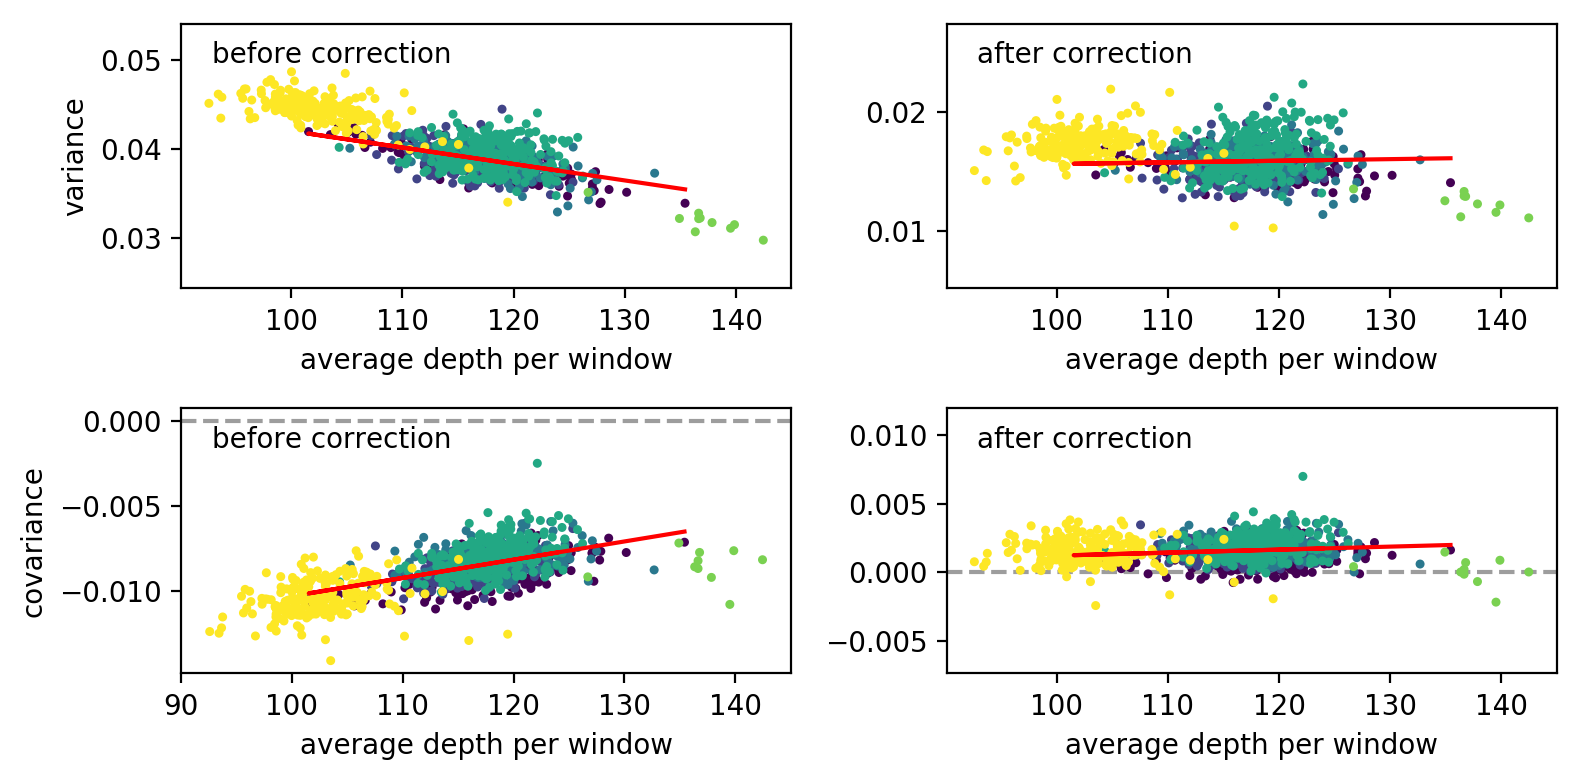

In [23]:
diagnostics = d.correction_diagnostics(exclude_seqids=['X', '4'])
_ = correction_diagnostic_plot(diagnostics)

with open("../data/barghi_et_al_2019/diagonistics_tuple.pkl", 'wb') as f:
    pickle.dump(diagnostics, f)

## Bootstrapping Covariances and G — Megabase tiles

We need a compromise over long enough blocks that it's reasonable to expect covariance between sites has broken down, and enough blocks that we don't have too "blocky" of a distribution of covariance bootstraps.

We use 1Mb tiles, but other runs may include smaller and larger window sizes.

In [24]:
megabase_tiles = GenomicIntervals.from_tiles(dsim.seqlens, width=1e6)
d.set_tiles(megabase_tiles)
print("number of blocks: ", len(d.tile_indices))

number of blocks:  108


In [25]:
megabase_tile_covs = d.calc_cov_by_tile(progress_bar=True)
megabase_tile_temp_covs = stack_temporal_covs_by_group(tile_covs, d.R, d.T)

with open(f'../data/barghi_et_al_2019/tile_temporal_covs_1e6.npy', 'wb') as f:
    np.save(f, megabase_tile_temp_covs)

### Tiled Temporal Covs with Megabase windows

In [26]:
tile_covs_megabase = d.calc_cov_by_tile(progress_bar=True)

tile_temp_covs_megabase = stack_temporal_covs_by_group(tile_covs_megabase, d.R, d.T)
with open('../data/barghi_et_al_2019/tile_temporal_covs_1e6.npy', 'wb') as f:
    np.save(f, tile_temp_covs_megabase)

### Bootstrapping Temporal Covs

Bootstrap the temporal covariances, averaging over all replicates.

In [27]:
gw_temp_covs_cis = d.bootstrap_cov(B=5000, average_replicates=True, progress_bar=True)

with open('../data/barghi_et_al_2019/gw_temp_covs_cis.npy', 'wb') as f:
    np.save(f, gw_temp_covs_cis)

Bootstrap the entire temporal-replicate covariance matrix.

In [28]:
gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

with open('../data/barghi_et_al_2019/gw_covs_cis.npy', 'wb') as f:
    np.save(f, gw_covs_cis)

### Bootstrapping G

First, we get the estimated G and save it:

In [29]:
g_estimate = d.calc_G(average_replicates=False)

with open('../data/barghi_et_al_2019/g_estimate.npy', 'wb') as f:
    np.save(f, g_estimate)

Bootstrap the measure G, not averaging over all replicates.

In [30]:
# G *not* averaging replicates
g_cis = d.bootstrap_G(B=5000, progress_bar=True)

with open('../data/barghi_et_al_2019/g_cis.npy', 'wb') as f:
    np.save(f, g_cis)

Bootstrap the measure G, averaging over all replicates.

In [31]:
# G averaging replicates
g_cis_averep = d.bootstrap_G(B=5000, average_replicates=True, progress_bar=True)

with open('../data/barghi_et_al_2019/g_cis_averep.npy', 'wb') as f:
    np.save(f, g_cis_averep)

### Bootstrap Whole Temporal-Replicate Covariance Matrix

In [174]:
temprep_covs_bs = d.bootstrap_cov(B=5000, progress_bar=True)

### Bootstrap the Convergence Correlation

In [17]:
conv_corr = d.convergence_corr()

In [34]:
with open('../data/barghi_et_al_2019/barghi_et_al_2019_conv_corr.npy', 'wb') as f:
    np.save(f, conv_corr)

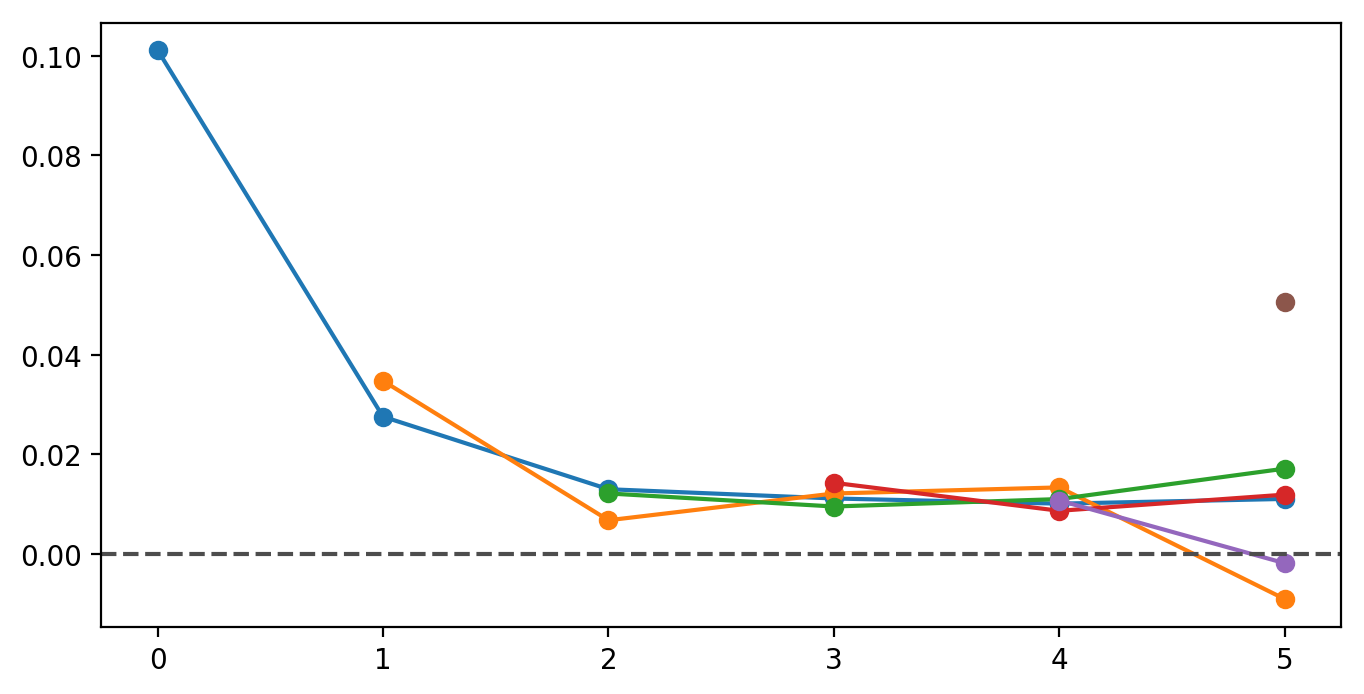

In [35]:
T = 6

for refgen in np.arange(T):
    plt.plot(np.arange(refgen, T), conv_corr[0, refgen, refgen:], '-o')
plt.axhline(0, linestyle='--', c='0.3')

### What's the one outlier?

In [73]:
covs = d.calc_cov()

A control:

(array([ 2.,  4.,  7.,  9.,  4., 10.,  6.,  1.,  0.,  2.]),
 array([-3.73235196e-04, -2.85264366e-04, -1.97293536e-04, -1.09322706e-04,
        -2.13518762e-05,  6.66189539e-05,  1.54589784e-04,  2.42560614e-04,
         3.30531444e-04,  4.18502274e-04,  5.06473104e-04]),
 <a list of 10 Patch objects>)

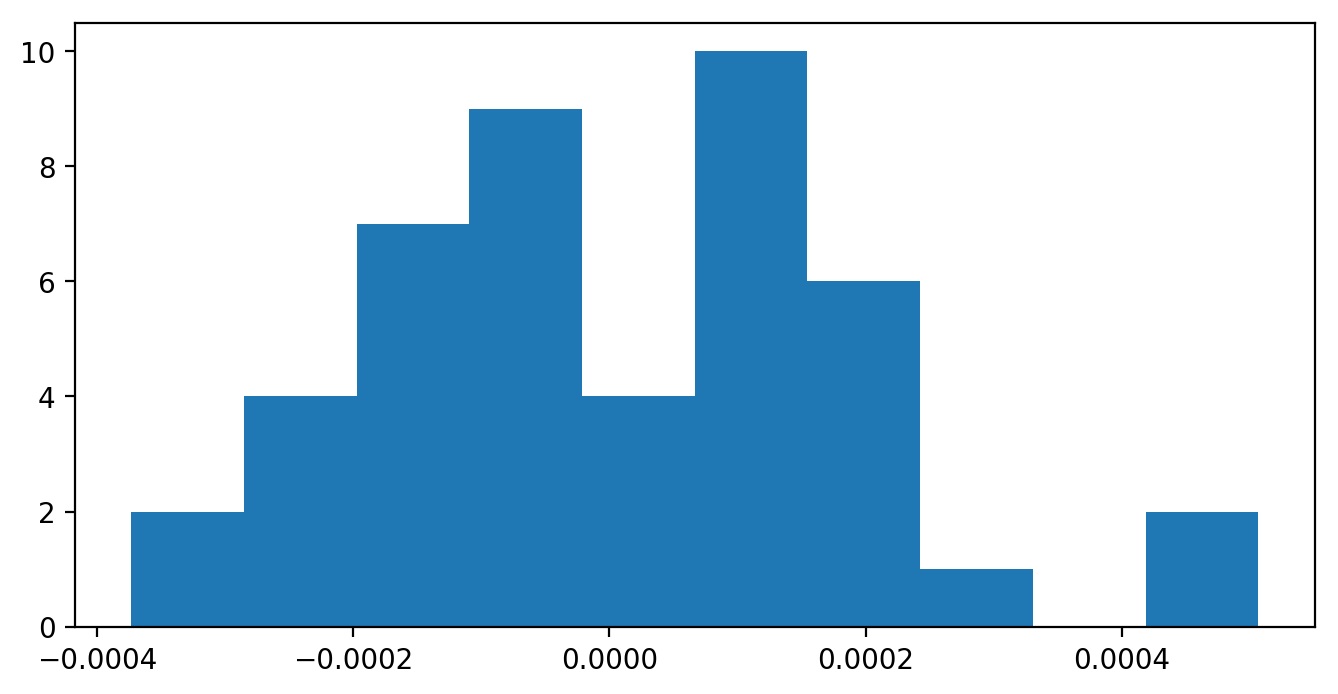

In [90]:
plt.hist(stack_replicate_covariances(covs, d.R, d.T, True)[4, 5, :])

Text(0.5, 0, 'convergence correlation')

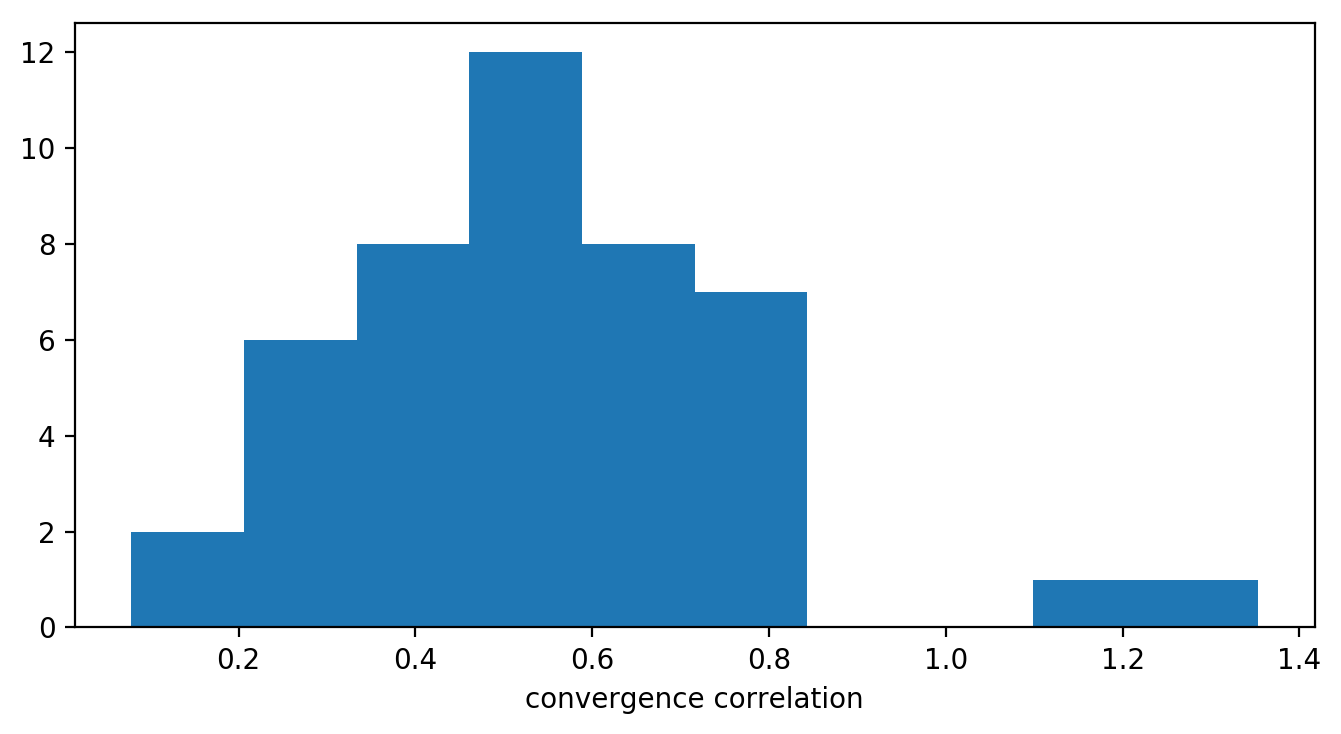

In [93]:
# 0.001 is approx denom
plt.hist(stack_replicate_covariances(covs, d.R, d.T, True)[5, 5, :]/0.001)
plt.xlabel('convergence correlation')

### Bootstraps

In [37]:
conv_corr_straps = d.bootstrap_convergence_corr(B=1000, progress_bar=True, return_straps=True)

(array([  1.,  31.,  53., 168., 254., 274., 123.,  64.,  27.,   5.]),
 array([0.00484302, 0.00612964, 0.00741626, 0.00870288, 0.0099895 ,
        0.01127612, 0.01256274, 0.01384936, 0.01513598, 0.0164226 ,
        0.01770922]),
 <a list of 10 Patch objects>)

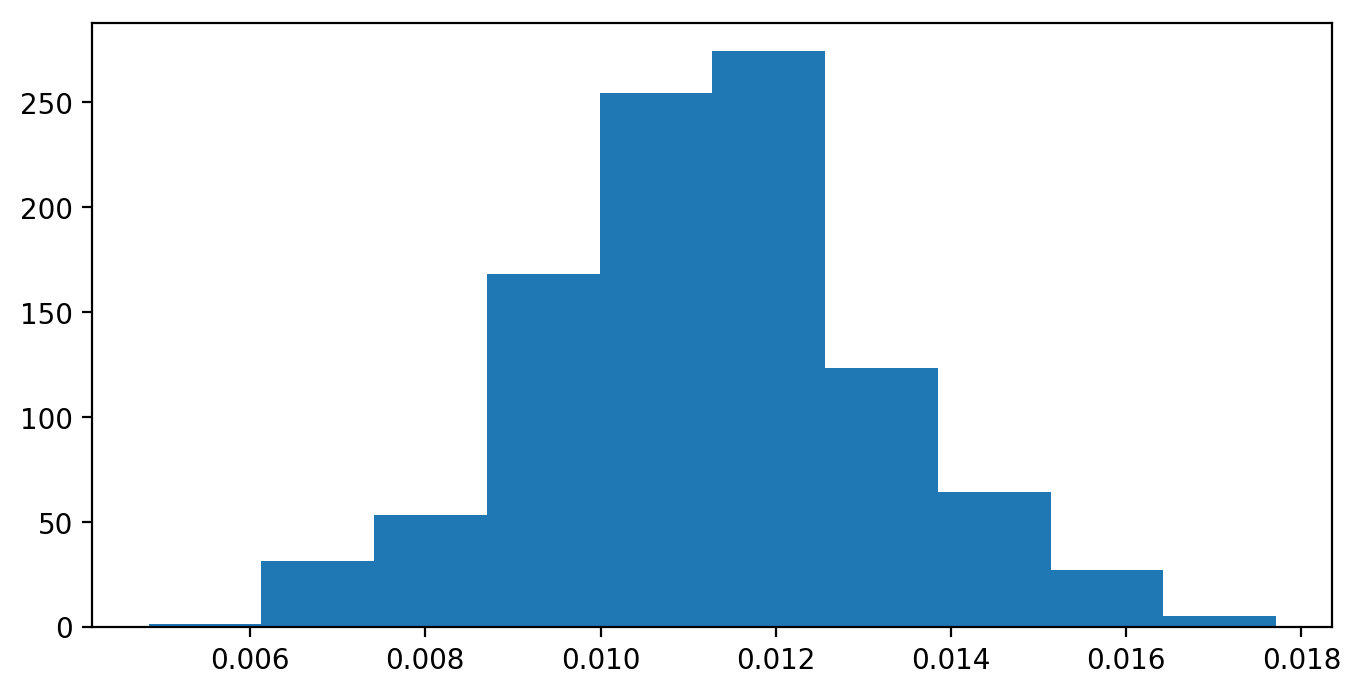

In [38]:
plt.hist(conv_corr_straps[:, 0, 5])

In [ ]:
conv_corr_average_of_ratio_cis = d.bootstrap_convergence_corr(B=100, ratio_of_averages=False, progress_bar=True)

In [128]:
with open('../data/barghi_et_al_2019/barghi_et_al_2019_conv_corr_cis_b100_average_of_ratio.npy', 'wb') as f:
    np.save(f, conv_corr_average_of_ratio_cis)

In [40]:
conv_corr_cis = d.bootstrap_convergence_corr(B=5000, ratio_of_averages=True, progress_bar=True)

In [41]:
with open('../data/barghi_et_al_2019/barghi_et_al_2019_conv_corr_cis.npy', 'wb') as f:
    np.save(f, conv_corr_cis)

### Empirical Null Distributions via Sign Permutation

These are memory intensive to calculate, so it may not be a bad idea to run one, restart the kernel and run pre-requisite lines above and let the code below save the object, and so on.

In [20]:
empnull_tile_width = 1e5
tile_label = '1e5'
empnull_tiles = GenomicIntervals.from_tiles(dsim.seqlens, width=empnull_tile_width)
d.set_tiles(empnull_tiles)
print("number of blocks: ", len(d.tile_indices))

number of blocks:  1106


Whether to force re-running of empirical nulls (computationally intensive) despite presence of cached results.

In [22]:
FORCE = False

#### Empirical Null for Tile-level sign permutation

In [26]:
CACHED_EMPCOV_TILE = f'../data/barghi_et_al_2019/empnull_tile_{tile_label}.npy'


# tile empirical null with tile-level block permutation (no bias correction)
if FORCE or not os.path.exists(CACHED_EMPCOV_TILE):
    empcov_tile = d.calc_empirical_null(B=1000, by_tile=True, sign_permute_blocks='tile',
                                        bias_correction=False, progress_bar=True)
    with open(CACHED_EMPCOV_TILE, 'wb') as f:
        np.save(f, empcov_tile)
else:   
    with open(CACHED_EMPCOV_TILE, 'rb') as f:
        empcov_tile = np.load(f)

/home/vinceb/projects/cvtk/cvtk/cov.py:283: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/vinceb/projects/cvtk/cvtk/cov.py:309: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(deltas, bias=True)
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


The following is optional for comparisions, it has not been run. 

In [ ]:
# CACHED_EMPCOV_TILE_WITH_CORRECTION = f'../data/barghi_et_al_2019/empnull_tile_with_bias_correction_{tile_label}.npy'

# # tile empirical null with tile-level block permutation (*with* bias correction)
# if FOR or not os.path.exists(CACHED_EMPCOV_TILE_WITH_CORRECTION):
#     empcov_tile_with_corr = d.calc_empirical_null(B=1000, by_tile=True, sign_permute_blocks='tile', 
#                                                   bias_correction=True,
#                                                   progress_bar=True)
#     with open(CACHED_EMPCOV_TILE_WITH_CORRECTION, 'wb') as f:
#         np.save(f, empcov_tile_with_corr)
# else:   
#     with open(CACHED_EMPCOV_TILE, 'rb') as f:
#         empcov_tile = np.load(f)  

#### Empirical Null for Chromosome-level sign permutation

In [ ]:
CACHED_EMPCOV_TILE_SEQID = f'../data/barghi_et_al_2019/empnull_seqid_{tile_label}.npy'

# tile empirical null with seqid-level block permutation (no bias correction)
if FORCE or not os.path.exists(CACHED_EMPCOV_TILE_SEQID):
    empcov_tile_seqid = d.calc_empirical_null(B=1000, by_tile=True, sign_permute_blocks='seqid',
                                              bias_correction=False,                                              
                                              progress_bar=True)
    with open(CACHED_EMPCOV_TILE_SEQID, 'wb') as f:
        np.save(f, empcov_tile_seqid)
else:   
    with open(CACHED_EMPCOV_TILE_SEQID, 'rb') as f:
        empcov_tile_seqid = np.load(f)

In [ ]:
CACHED_EMPCOV_GW = f'../data/barghi_et_al_2019/empnull_reshape_gw_{tile_label}.npy'

# genome-wide empirical null (no bias correction)
if FORCE or not os.path.exists(CACHED_EMPCOV_GW):
    empcov_gw = d.calc_empirical_null(B=1000, by_tile=False,
                                      bias_correction=False,                                      
                                      progress_bar=True)
    with open(CACHED_EMPCOV_GW, 'wb') as f:
        np.save(f, empcov_gw)
else:
    with open(CACHED_EMPCOV_GW, 'rb') as f:
        empcov_gw = np.load(f)

## PCA of Samples

In [30]:
pca = FreqPCA(sf.freqs)
pc_df= pca.to_df()
# add in the sample info:
pc_df[['rep', 'gen']] = design[['rep', 'gen']]
pc_df.to_csv('../data/barghi_et_al_2019/pca_df.csv', index=False)

(<Figure size 1600x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f154a3b6390>)

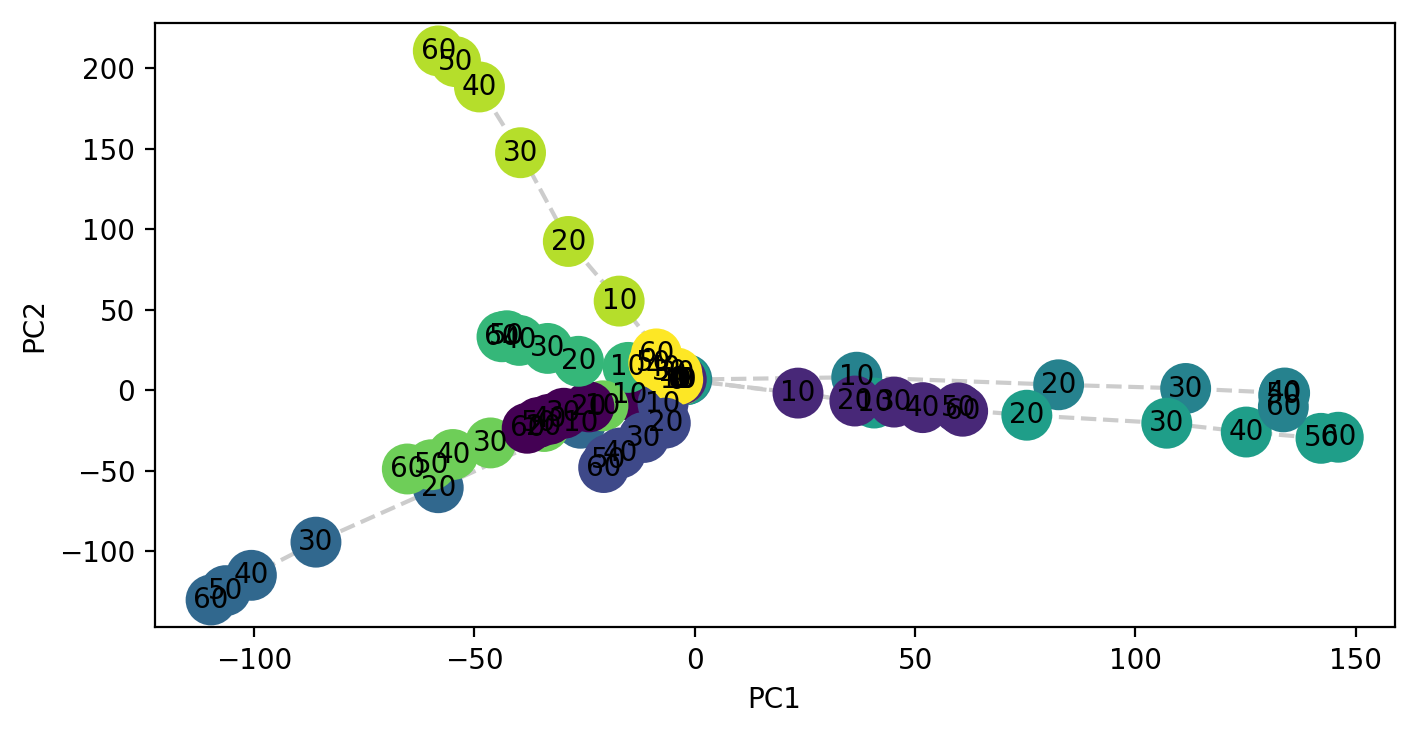

In [28]:
from cvtk.plots import rep_plot_pca2

rep_plot_pca2(pc_df, 1,2)


<module 'matplotlib.pyplot' from '/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/matplotlib/pyplot.py'>

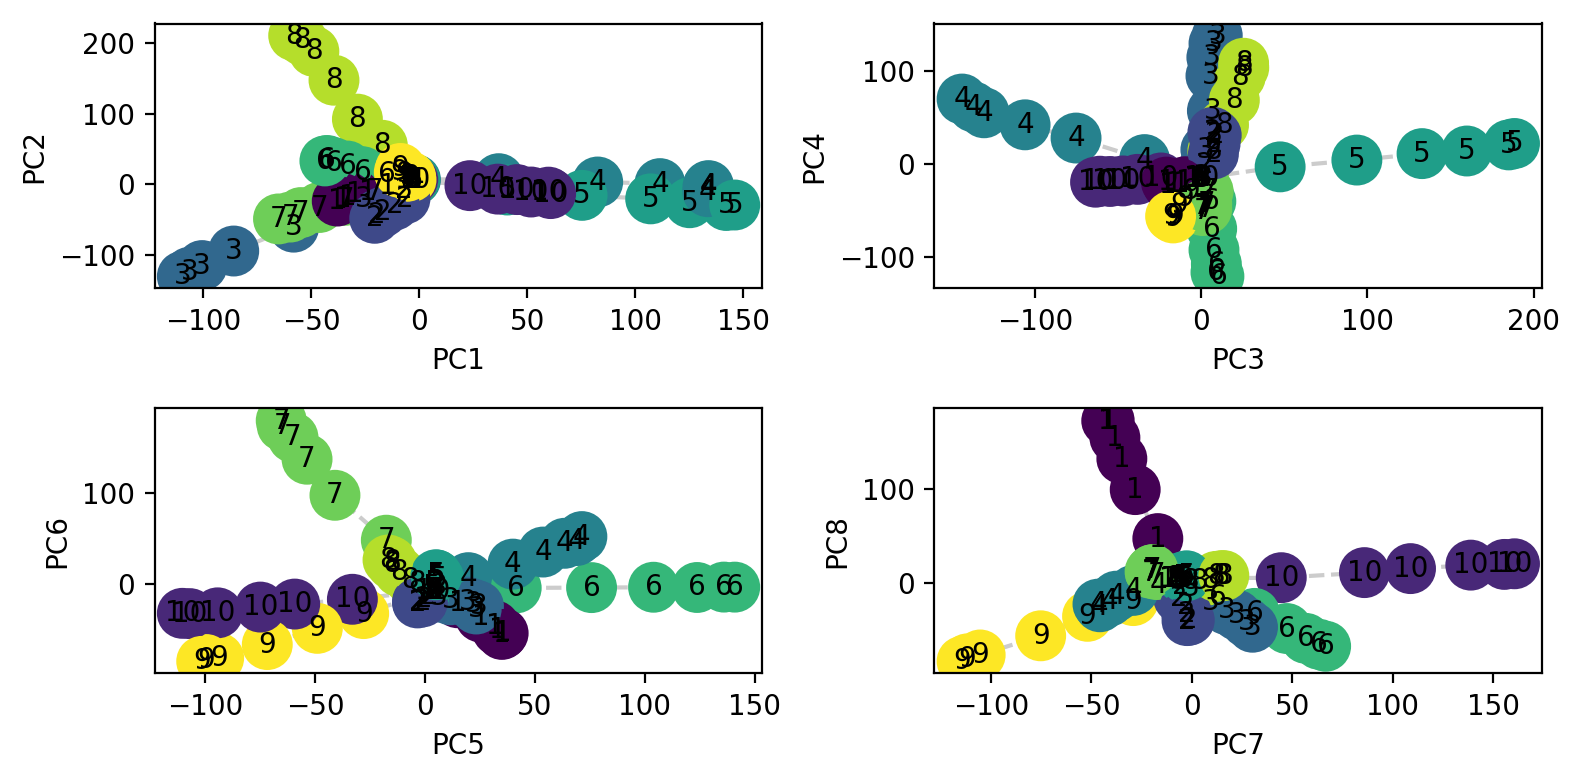

In [22]:
plt.subplot(221)
rep_plot_pca(pc_df, 1, 2)
plt.subplot(222)
rep_plot_pca(pc_df, 3, 4)
plt.subplot(223)
rep_plot_pca(pc_df, 5, 6)
plt.subplot(224)
rep_plot_pca(pc_df, 7, 8)

# OLD STUFF

### SVD 

In [117]:
res = [optimal_N_svd(b, i, progress_bar=True) for i in np.arange(d.R)]

ValueError: attempt to get argmin of an empty sequence

### Alternate G

In [20]:
gw_temp_covs = stack_temporal_covariances(d.calc_covs(standardize=False), d.R, d.T)

In [51]:
from cvtk.cov import total_variance
gw_vars = np.stack([total_variance(d.freqs, t=t, standardize=False) for t in np.arange(d.T+1)])

In [52]:
gw_vars

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00358565, 0.00323979, 0.00381784, 0.00389675, 0.00398064,
        0.00404773, 0.00412002, 0.0042057 , 0.00360681, 0.00481083],
       [0.00574614, 0.00619016, 0.00643623, 0.00724996, 0.00656742,
        0.00575917, 0.00676889, 0.006079  , 0.00590314, 0.00955782],
       [0.00798318, 0.00787952, 0.01013637, 0.01039705, 0.01064503,
        0.00893601, 0.00900319, 0.00911941, 0.00730285, 0.00787342],
       [0.0092355 , 0.00949005, 0.0121434 , 0.01294969, 0.01174627,
        0.01035427, 0.01069503, 0.01316417, 0.01073234, 0.01061904],
       [0.01107629, 0.01179483, 0.01438041, 0.01383625, 0.01486565,
        0.01203857, 0.01212723, 0.01486421, 0.01117223, 0.01290793],
       [0.01161521, 0.01270751, 0.01633829, 0.01575887, 0.01590283,
        0.01339248, 0.01341168, 0.01666055, 0.01248348, 0.01410008]])

In [53]:
gw_vars.mean(axis=1)

array([0.        , 0.00393118, 0.00662579, 0.0089276 , 0.01111298,
       0.01290636, 0.0142371 ])

In [54]:
gw_covs = gw_temp_covs.mean(axis=2)

In [55]:
gw_vars.mean(axis=1)

array([0.        , 0.00393118, 0.00662579, 0.0089276 , 0.01111298,
       0.01290636, 0.0142371 ])

/home/vinceb/projects/cvtk/cvtk/G.py:25: RuntimeWarning: invalid value encountered in true_divide
  G = total_cov / total_var
/home/vinceb/projects/cvtk/cvtk/G.py:25: RuntimeWarning: divide by zero encountered in true_divide
  G = total_cov / total_var


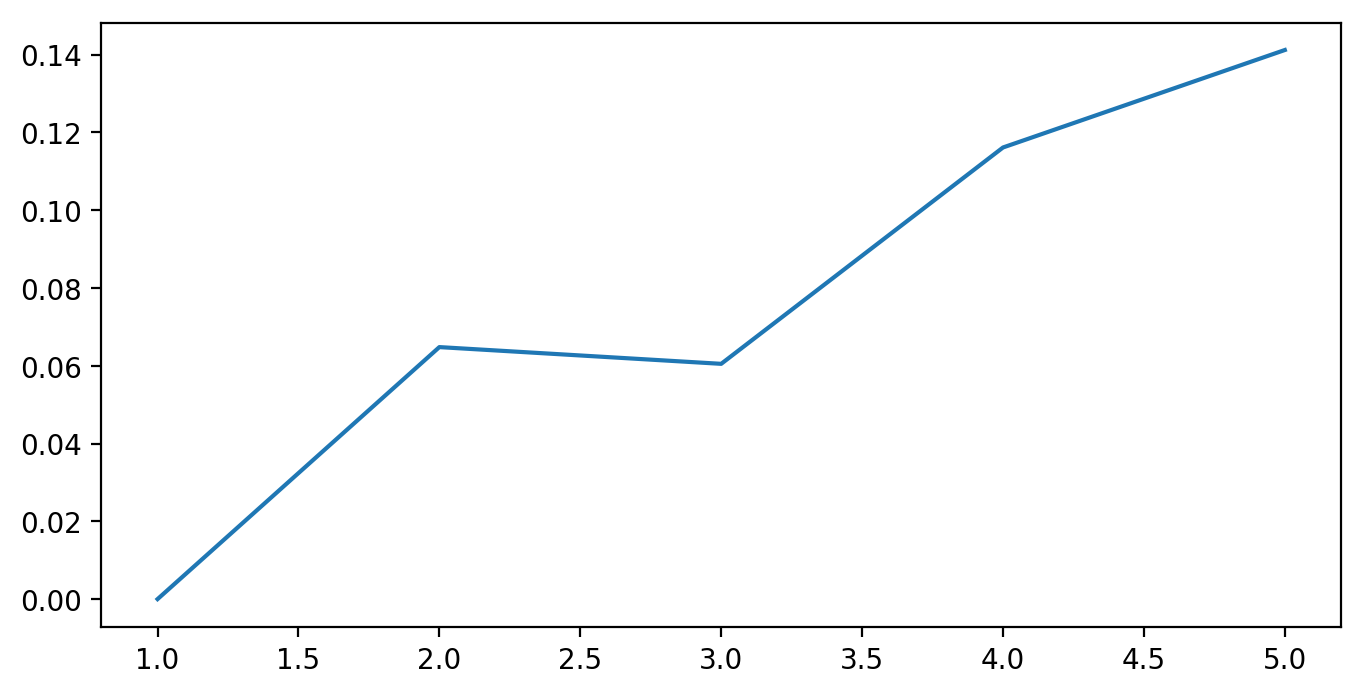

In [56]:
plt.plot(np.arange(1, d.T), [calc_G2(gw_covs, gw_vars.mean(axis=1), end=t)[t] for t in np.arange(1, d.T)])

In [62]:
from cvtk.G import calc_G2
rep_Gs = []
for rep in np.arange(d.R):
    rep_Gs.append([calc_G2(gw_temp_covs[:, :, rep], gw_vars[:, rep][t], end=t) for t in np.arange(d.T+1)])

/home/vinceb/projects/cvtk/cvtk/G.py:25: RuntimeWarning: invalid value encountered in double_scalars
  G = total_cov / total_var


In [63]:
np.stack(rep_Gs).shape

(10, 7)

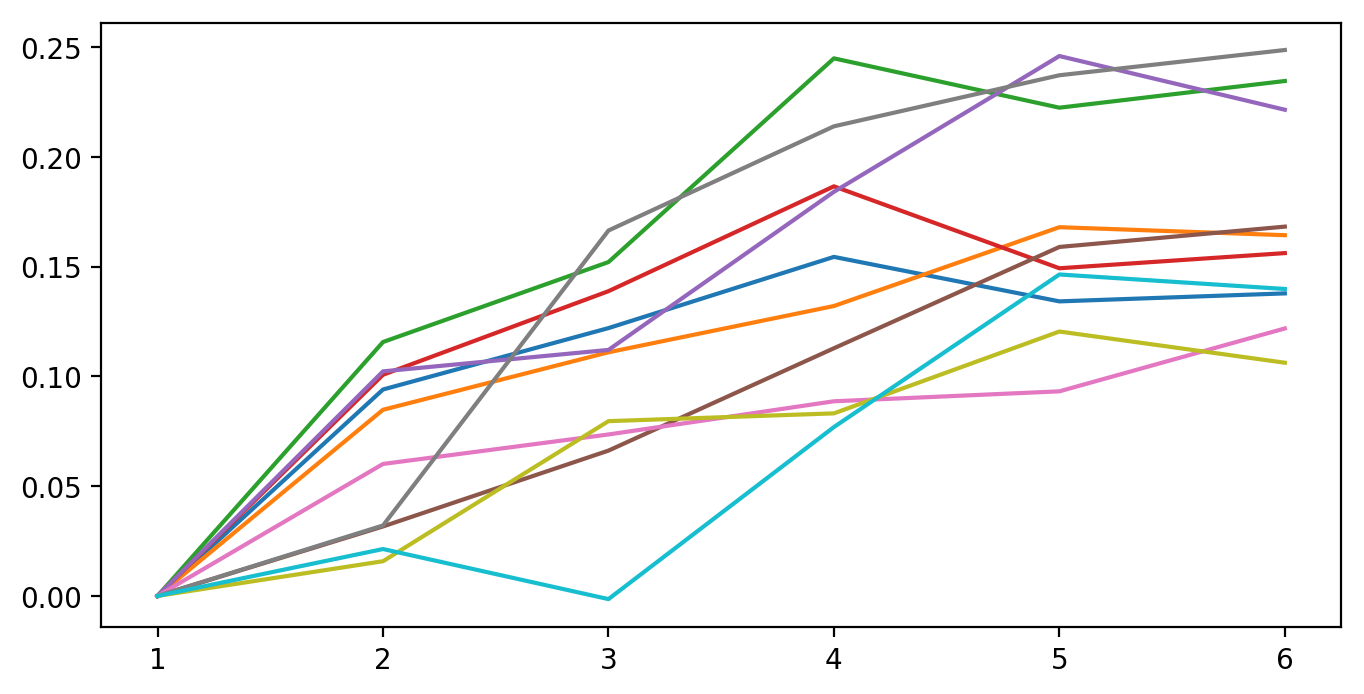

In [66]:
plt.plot(np.stack(rep_Gs).T)

In [24]:
np.stack(d.calc_var_by_tile()).shape

(1106, 10)

In [64]:
gw_covs = gw_temp_covs.mean(axis=2)

In [396]:
gw_covs

array([[ 1.99536665e-02,  1.98915571e-03,  5.13228705e-04,
         5.64226255e-04, -1.46022807e-05, -3.51259497e-04],
       [ 1.98915571e-03,             nan,             nan,
         5.76140898e-04,  2.68059077e-04, -2.61950388e-04],
       [ 5.13228705e-04,             nan,             nan,
         2.45187998e-03,  9.89769514e-04,  2.77426937e-04],
       [ 5.64226255e-04,  5.76140898e-04,  2.45187998e-03,
         1.67597782e-02,  1.35323507e-03,  1.30402633e-04],
       [-1.46022807e-05,  2.68059077e-04,  9.89769514e-04,
         1.35323507e-03,  1.27813475e-02,  1.58093148e-03],
       [-3.51259497e-04, -2.61950388e-04,  2.77426937e-04,
         1.30402633e-04,  1.58093148e-03,  1.07419270e-02]])

In [404]:
#[plt.plot(np.arange(t, 5), gw_covs[t, (t+1):], '-o') for t in np.arange(d.T)]


array([[0.        , 0.        , 0.05778172, 0.09042584, 0.13037347,
        0.14452188, 0.14172667],
       [0.        , 0.        , 0.06206277, 0.0951566 , 0.13475107,
        0.14993367, 0.14525115],
       [0.        , 0.        , 0.06434085, 0.09954967, 0.13917947,
        0.15478225, 0.15152296]])